In [1]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import os
from os import path
import re
from tqdm import tqdm  
from PIL import Image   
from multiprocessing import Pool

Using TensorFlow backend.


In [2]:
root="./"
SIZE = 120
DATA_DIR=path.join(root,"img_aling_celeba")
DATA_DIR

'./img_aling_celeba'

In [3]:
face_images = glob.glob('img_align_celeba/*.jpg')
print(len(face_images)) 

202599


In [4]:
test_size=1000
X=face_images[test_size:]
X_test=face_images[:test_size]
X_train,X_val = train_test_split(X, test_size=0.3, random_state=42)

In [5]:
def load(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    dim = (45, 45)  
    img_px= tf.image.resize(img, dim,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    dim = (SIZE, SIZE)  
    img_px= tf.image.resize(img_px, dim,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img=tf.image.resize(img, dim,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_px, img

def generator(X,batch=32):
    data = tf.data.Dataset.from_tensor_slices(X)
    data= data.map(
    load, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch)
    return data

In [6]:
train =generator(X_train,batch=64)
val=generator(X_val,batch=64)

(120, 120, 3) (120, 120, 3)


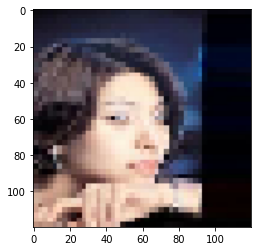

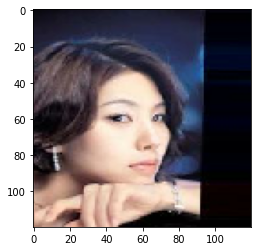

In [7]:
for x, y in train:
    print(x[0].shape,y[0].shape)
    plt.imshow(x[0])
    plt.show()
    plt.imshow(y[0])
    plt.show()
    break

In [8]:
Input_img = Input(shape=(SIZE, SIZE, 3)) 

 #encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

In [9]:
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 120, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 120, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 60, 60, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [10]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=2, mode='min')
model_checkpoint = ModelCheckpoint('superResolution.h5',save_best_only=True)

In [11]:
%%time
history = autoencoder.fit(train,
            epochs=10,
            validation_data=val,
            callbacks=[model_checkpoint])

Epoch 1/10
2205/2205 [==============================] - 2388s 1s/step - loss: 193.9330 - accuracy: 0.9104 - val_loss: 163.0190 - val_accuracy: 0.9158
Epoch 2/10
2205/2205 [==============================] - 2311s 1s/step - loss: 158.6754 - accuracy: 0.9220 - val_loss: 159.4304 - val_accuracy: 0.9080
Epoch 3/10
2205/2205 [==============================] - 2345s 1s/step - loss: 153.0046 - accuracy: 0.9254 - val_loss: 152.1797 - val_accuracy: 0.9439
Epoch 4/10
2205/2205 [==============================] - 2327s 1s/step - loss: 149.6180 - accuracy: 0.9282 - val_loss: 149.5294 - val_accuracy: 0.9264
Epoch 5/10
1370/2205 [=================>............] - ETA: 11:38 - loss: 147.4723 - accuracy: 0.9301

In [ ]:
autoencoder = tf.keras.models.load_model('superResolution.h5')

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    #low=cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.show()

In [ ]:
for i in range(20,30):
    #predicted = autoencoder.predict(val_x_px[i])
    predicted = np.clip(autoencoder.predict(test_x_px[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_x[i],test_x_px[i],predicted)


In [ ]:
results = autoencoder.evaluate(test_x_px, test_x)
print('loss, accuracy', results)